# Initial Analysis

This notebook computes several metrics and performs an initial analysis of the portfolio options. The basis of this initial analysis is to get a list of ranked funds so that computation can be minimised afterwards.

Note: This notebook assumes that you have loaded data within the `data/portfolios.json` and `data/pricing` by running the `init.py`. It also assumes that you've run all the notebooks with prior numbering.


In [112]:
# Lib imports.
import pandas as pd
pd.set_option("expand_frame_repr", False)
from pypfopt.expected_returns import mean_historical_return
from pypfopt.risk_models import CovarianceShrinkage
from pypfopt.plotting import plot_covariance

# Local.
from parser.loader import get_all_portfolios_as_dict, DataFormat
from strategies.ranking import rank_funds, COL_TOTAL

In [113]:
# Constants
DATA_PATH = "data/pricing"
FUNDS_PATH = "data/portfolios.json"

# Columns.
COLUMN_DATE = "asOfDate"
COLUMN_PRICE = "price"

# Data
RISK_FREE_RATE_UK = 0.0106

## Loading & Ranking

We start by loading all the data.


In [114]:
portfolios = get_all_portfolios_as_dict(
    risk_free_rate=RISK_FREE_RATE_UK, data_format=DataFormat.RAW
)
portfolios_df = pd.DataFrame(
    [
        {
            "name": port["name"],
            "type": port["type"],
            "id": port["id"],
            "expense_ratio": port["expense_ratio"],
            "y1_return": port["y1_return"],
            "y5_return": port["y5_return"],
            "daily_return": port["daily_return"],
            "volatility": port["volatility"],
            "average_return": port["average_return"],
            "excess_return": port["excess_return"],
            "sharpe_ratio": port["sharpe_ratio"],
        }
        for port in portfolios.values()
    ]
)
print(f"Loaded {portfolios_df.shape} (rows x cols)")

Loaded (156, 11) (rows x cols)


We need to rank the funds and then keep the fund with the biggest index. This is because we have types based on accumulation or distribution.

In [115]:
ranked_funds_complete = rank_funds(portfolios_df)
idx = ranked_funds_complete.groupby("name")[COL_TOTAL].idxmax()
ranked_funds = ranked_funds_complete.loc[idx].sort_values(by=COL_TOTAL, ascending=False)

# Will write the result in a csv.
ranked_funds_complete.to_csv("data/output/complete_ranking.csv", index=False)

Using all the data, we can keep a list of the funds we "like" the most.

In [116]:
df_filter = ["name", "type", COL_TOTAL]
LIMIT = 30

In [117]:
top_ranking_funds = ranked_funds.head(LIMIT)
print("Top Ranked\n", top_ranking_funds[df_filter])

Top Ranked
                                                   name                 type  total_score
127                                  S&P 500 UCITS ETF         Accumulation     0.803314
121                       FTSE North America UCITS ETF         Accumulation     0.802003
148                ESG North America All Cap UCITS ETF         Accumulation     0.784436
116                     FTSE Developed World UCITS ETF         Accumulation     0.782764
120                           FTSE All-World UCITS ETF         Accumulation     0.777924
67                        ESG Global All Cap UCITS ETF         Accumulation     0.767836
95      USD Emerging Markets Government Bond UCITS ETF         Accumulation     0.713859
118       FTSE All-World High Dividend Yield UCITS ETF         Accumulation     0.693452
93               USD Corporate 1-3 Year Bond UCITS ETF         Accumulation     0.675652
142             ESG Developed Europe All Cap UCITS ETF         Accumulation     0.653134
119      

In [118]:
print("Bottom Rank\n", ranked_funds.tail(LIMIT)[df_filter])

Bottom Rank
                                                  name                 type  total_score
87     ESG Emerging Markets All Cap Equity Index Fund         Accumulation     0.509610
45                      LifeStrategy® 20% Equity Fund         Accumulation     0.508569
15                  Pacific ex-Japan Stock Index Fund         Accumulation     0.507678
4                     Euro Government Bond Index Fund  Hedged Accumulation     0.498674
31                 FTSE U.K. Equity Income Index Fund         Accumulation     0.497208
56                                 Global Equity Fund         Accumulation     0.494781
62                 SustainableLife 60-70% Equity Fund         Accumulation     0.489618
6               U.K. Investment Grade Bond Index Fund         Accumulation     0.487976
35    FTSE Developed Europe ex-U.K. Equity Index Fund         Accumulation     0.484784
117    FTSE Developed Asia Pacific ex Japan UCITS ETF         Accumulation     0.479906
96                 

You may note that right away you can spot some correlation between some of the top performers, for example, S&P 500 and all the North America funds. To verify this, we can keep the top funds and then run a covariance.

In [119]:
VERBOSE = True
# Get the minimum date across all of them.
min_date = max(
    [
        min(portfolios[id]["pricing"].index)
        for id in top_ranking_funds["id"]
    ]
)

# Concat all of them.
complete_top_ranking = None

for id in top_ranking_funds["id"]:
    __df: pd.DataFrame = portfolios[id]["pricing"]
    __df = __df[__df.index >= min_date][["price"]]
    __df = __df.rename(
        columns={"price": portfolios[id]['name'] + (f" ({portfolios[id]['type']})" if VERBOSE else "")}
    )
    complete_top_ranking = (
        __df if complete_top_ranking is None else complete_top_ranking
    ).combine_first(__df)

complete_top_ranking

,ESG Developed Europe All Cap UCITS ETF (Accumulation),ESG Developed World All Cap Equity Index Fund (Accumulation),ESG Developed World All Cap Equity Index Fund (UK) (Accumulation),ESG EUR Corporate Bond UCITS ETF (Hedged Accumulation),ESG Emerging Markets All Cap UCITS ETF (Accumulation),ESG Global All Cap UCITS ETF (Accumulation),ESG Global Corporate Bond UCITS ETF (Hedged Accumulation),ESG North America All Cap UCITS ETF (Accumulation),EUR Corporate Bond UCITS ETF (Accumulation),Emerging Markets Bond Fund (Hedged Accumulation),...,Global Credit Bond Fund (Hedged Accumulation),Global Short-Term Bond Index Fund (Hedged Accumulation),Global Short-Term Corporate Bond Index Fund (Hedged Accumulation),Global Sustainable Equity Fund (Accumulation),LifeStrategy® 80% Equity Fund (Accumulation),S&P 500 UCITS ETF (Accumulation),U.S. Equity Index Fund (Accumulation),USD Corporate 1-3 Year Bond UCITS ETF (Accumulation),USD Corporate Bond UCITS ETF (Accumulation),USD Emerging Markets Government Bond UCITS ETF (Accumulation)
asOfDate,,,,,,,,,,,,,,,,,,,,,
2022-11-15,4.8543,340.8157,125.3828,5.0000,5.4856,4.5421,4.2934,4.5434,45.9072,98.1548,...,103.7697,104.1938,99.2020,99.9536,250.2145,73.9097,739.2110,51.5040,50.2839,47.0920
2022-11-16,4.7967,337.7260,124.3107,5.0167,5.4445,4.5020,4.3177,4.4986,46.0677,98.5808,...,104.7342,104.3085,99.3434,99.9053,249.2420,73.3140,732.0000,51.5249,50.6326,47.3144
2022-11-17,4.7781,338.8850,124.7431,5.0123,5.3934,4.4726,4.3049,4.4784,46.0183,97.7156,...,104.3885,104.1650,99.1888,100.5852,249.5841,73.1001,736.0911,51.4617,50.4074,47.0138
2022-11-18,4.8358,336.7440,123.9540,5.0222,5.4011,4.4981,4.3051,4.4988,46.1108,97.5044,...,103.9440,104.1210,98.9994,100.2784,248.7532,73.4497,730.3452,51.4266,50.3803,46.9245
2022-11-21,4.8451,338.4695,124.5905,5.0295,5.3464,4.4659,4.3120,4.4767,46.1791,97.3762,...,104.4641,104.1333,99.0444,101.0068,249.5991,73.1783,735.8529,51.4295,50.4379,46.9064
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-10-07,6.1738,438.9863,161.9063,5.6932,7.1164,6.3917,4.8337,6.6722,51.0251,121.8095,...,117.8599,113.3190,110.6814,128.2506,302.8724,108.0480,964.7436,57.3464,57.6702,56.5702
2024-10-08,6.1584,441.1903,162.7190,5.6944,6.9785,6.4128,4.8365,6.7462,51.0338,121.7384,...,118.1892,113.3668,110.7438,128.3108,302.4347,109.0952,972.1448,57.3808,57.7143,56.5678
2024-10-09,6.2013,444.6239,163.9889,5.6942,6.9199,6.4433,4.8308,6.7964,51.0263,120.8782,...,118.0434,113.3986,110.4597,128.9891,303.8748,109.8736,980.4537,57.3472,57.5987,56.5300


Correlation matrix can tell us how to diversify the portfolio better.

/Users/gonzalo/repository/python-fund-trading-bots/.env/lib/python3.11/site-packages/pypfopt/expected_returns.py:56: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns = prices.pct_change().dropna(how="all")
/Users/gonzalo/repository/python-fund-trading-bots/.env/lib/python3.11/site-packages/pypfopt/expected_returns.py:56: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns = prices.pct_change().dropna(how="all")
/Users/gonzalo/repository/python-fund-trading-bots/.env/lib/python3.11/site-packages/pypfopt/plotting.py:41: UserWarning: Tight layout not applied. The bottom and top margins

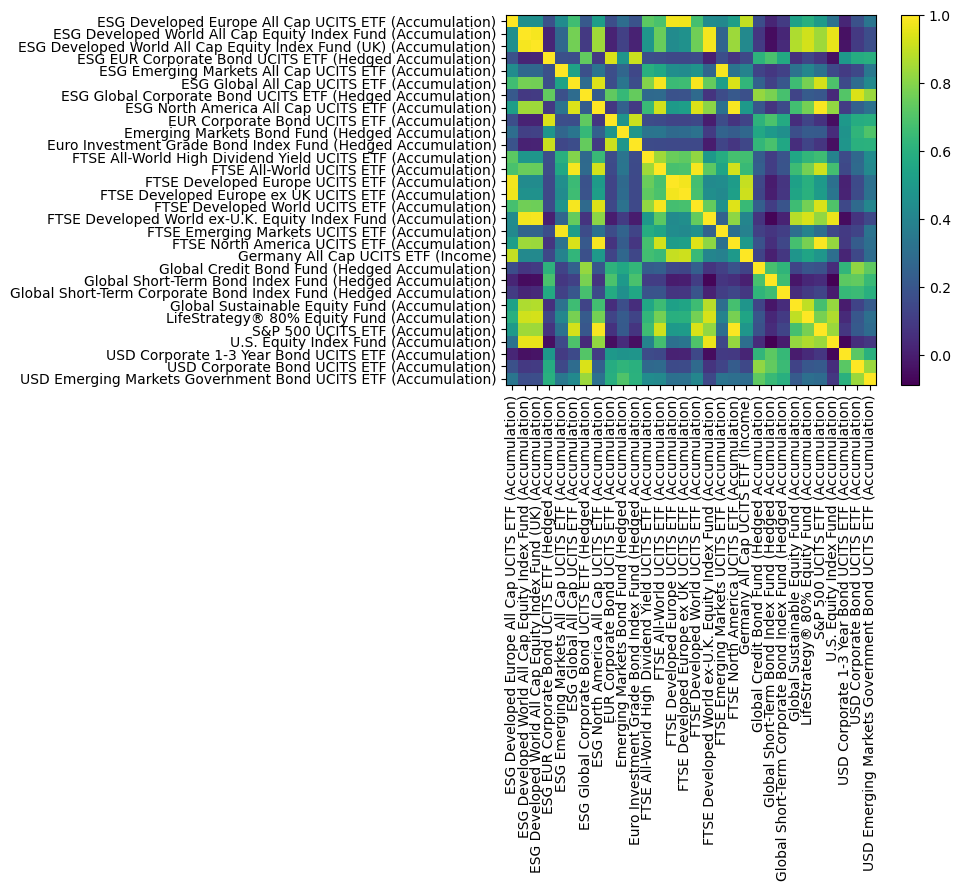

In [120]:
mu = mean_historical_return(complete_top_ranking)
cov = CovarianceShrinkage(complete_top_ranking).ledoit_wolf()
plot_covariance(cov, plot_correlation=True)

Saving results for use later.

In [121]:
complete_top_ranking.to_csv("data/output/complete_top_ranking.csv")